# 한글 스팸 이메일 분류
### BoB 13기 보안제품개발트랙 고예준

1. 데이터 불러오기
2. 피처 엔지니어링
3. 탐색적 데이터 분석(EDA)을 통한 시각화
4. 학습 및 테스트 데이터 분할
5. 여러 분류 모델(Decision Tree, XGBoost, Logistic Regression 등)로 학습
6. 모델 성능 비교 및 시각화
7. 사용자 입력에 대한 스팸 여부 예측 함수 작성

# 0. 라이브러리 설치

In [145]:
%pip install pandas googletrans==4.0.0-rc1 numpy scikit-learn xgboost matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier


## 0. 데이터 수집

학습에 사용하기 위한 데이터로는 kaggle에 있는 영문 이메일 데이터 셋을 한글로 번역한 데이터와 한글 스팸 이메일 데이터를 사용하였습니다.<br/>
`emails.csv` 파일 전체를 번역하는데는 약 100분 정도가 소요됩니다.

In [147]:
import pandas as pd
from googletrans import Translator

In [148]:
# input_csv = 'emails.csv'
# df = pd.read_csv(input_csv)

In [149]:
# # Initialize the translator
# translator = Translator()

# # Define a function to translate text from English to Korean.
# def translate_text(text):
#     try:
#         # Translate the text to Korean (dest='ko')
#         translation = translator.translate(text, dest='ko')
#         return translation.text
#     except Exception as e:
#         print("Error translating text:", text, e)
#         return text

In [150]:
# # Apply the translation function to the "text" column.
# df['text'] = df['text'].apply(translate_text)

# # Save the translated dataset to a new CSV file.
# output_csv = 'spam_translated.csv'
# df.to_csv(output_csv, index=False)
# print("Translation complete. Translated file saved as", output_csv)

# 1. 데이터 개요

기본적으로 스팸 메일은 수신자의 동의 없이 대량으로 전송되는 원치 않는 이메일 메시지를 말합니다.<br/>
따라서 광고성 정보 수신동의에 의한 메일을 스팸메일이라고 보기에는 어려움이 있으나 최근에는 네이버와 gmail의 경우 기본적으로 메일 클라이언트에서 스팸메일을 전부 필터링하고 있어 사용자의 보관함에 메일이 존재하지 않습니다.<br/>

이에 본 학습에서는 충분한 데이터 확보를 위하여 kaggle의 스팸 이메일을 한글로 번역한 데이터와 한글로된 광고성 이메일을 사용하여 광고성 메일 또한 스팸메일로 간주하여 분류하였습니다.

In [151]:
import pandas as pd

# Load two CSV files (adjust file names/paths as needed)
df1 = pd.read_csv('spam_translated.csv')
df2 = pd.read_csv('collected_spam_email.csv')
df3 = pd.read_csv('spam_email_generated.csv')

# Concatenate the three DataFrames into one dataset
df = pd.concat([df1, df2, df3], ignore_index=True)

print("First 5 rows of the combined dataset:")
print(df.head())

print("\nData types and missing value info:")
df.info()

print("\nNumber of missing values per column:")
print(df.isnull().sum())

print("\nStatistical summary of numeric features:")
print(df.describe())

First 5 rows of the combined dataset:
                                                text  spam
0  제목 : 자연스럽게 저항 할 수없는 회사의 정체성 LT는 회사를 회상하기가 정말 어...     1
1  주제 : 주식 거래 총잡이 패니는 메릴이지만 콜자 아스트레더가 아니라 콜자가 아닌 ...     1
2  제목 : 믿을 수없는 새 주택은 당신에게 미리 454 달러, 169 달러의 주택 융...     1
3  제목 : 4 컬러 인쇄 특별 요청 추가 정보!여기를 클릭하여 여기를 클릭하십시오. ...     1
4  제목 : 돈이없고 여기에서 소프트웨어 CD를 얻으십시오!소프트웨어 호환성....대단...     1

Data types and missing value info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6733 entries, 0 to 6732
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6733 non-null   object
 1   spam    6733 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 105.3+ KB

Number of missing values per column:
text    0
spam    0
dtype: int64

Statistical summary of numeric features:
              spam
count  6733.000000
mean      0.278182
std       0.448137
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max  

# 2. 피처 엔지니어링

메일 텍스트에서 학습에 필요한 정보들을 다음과 같은 기준으로 생성했습니다.

- **메일 길이:** 전체 문자 수  
- **단어 수:** 공백을 기준으로 한 단어 수  
- **숫자 수:** 0-9 숫자의 등장 횟수  
- **특수문자 수:** 지정된 특수문자(!, ?, @, #, $, %, ^, &, *, (, )) 등장 횟수  
- **스팸 키워드 포함 횟수:** "무료", "당첨", "이벤트" 등 스팸에 자주 등장하는 단어들의 등장 횟수  
- **한글 비율:** 전체 문자 대비 한글(가-힣) 문자의 비율  
- **연속 반복 문자 수:** 같은 문자가 3번 이상 반복되는 패턴의 개수

In [152]:
import re

def feature_engineering(df):
    # 메일 길이
    df['length'] = df['text'].apply(len)
    
    # 단어 수
    df['word_count'] = df['text'].apply(lambda x: len(x.split()))
    
    # 숫자 수
    df['num_digits'] = df['text'].apply(lambda x: sum(c.isdigit() for c in x))
    
    # 특수문자 수 (예: !, ?, @, #, $, %, ^, &, *, (, ))
    special_chars = set(['!', '?', '@', '#', '$', '%', '^', '&', '*', '(', ')'])
    df['num_special_chars'] = df['text'].apply(lambda x: sum(c in special_chars for c in x))
    
    # 스팸 키워드 포함 횟수
    spam_keywords = ["무료", "당첨", "이벤트", "광고", "회원", "대출", "카드", "보상", "긴급", "특가", "약물", "투자", "주식", "성인", "배팅", "도박", "채용", "지원", "VIP", "vip", "혜택", "할인", "무료", "당첨", "이벤트", "광고", "회원", "대출", "카드", "보상", "긴급", "특가", "약물", "투자", "주식", "성인", "배팅", "도박", "채용", "지원", "VIP", "vip", "혜택", "할인"]
    def count_spam_keywords(text):
        count = 0
        for kw in spam_keywords:
            count += text.count(kw)
        return count
    df['num_spam_keywords'] = df['text'].apply(count_spam_keywords)
    
    # 한글 비율: 전체 문자 대비 한글(가-힣) 문자 비율
    def hangul_ratio(text):
        total = len(text)
        if total == 0:
            return 0
        count_hangul = sum(1 for c in text if '가' <= c <= '힣')
        return count_hangul / total
    df['hangul_ratio'] = df['text'].apply(hangul_ratio)
    
    # 연속 반복 문자 수 (같은 문자가 3번 이상 반복되는 경우)
    def count_repeated_sequences(text):
        matches = re.findall(r'(.)\1\1+', text)
        return len(matches)
    df['repeated_seq'] = df['text'].apply(count_repeated_sequences)
    
    return df

# 피처 엔지니어링 적용
df = feature_engineering(df)

df.head()

,text,spam,length,word_count,num_digits,num_special_chars,num_spam_keywords,hangul_ratio,repeated_seq
0,제목 : 자연스럽게 저항 할 수없는 회사의 정체성 LT는 회사를 회상하기가 정말 어...,1,817,241,4,1,2,0.450428,1
1,주제 : 주식 거래 총잡이 패니는 메릴이지만 콜자 아스트레더가 아니라 콜자가 아닌 ...,1,287,59,0,0,2,0.466899,0
2,"제목 : 믿을 수없는 새 주택은 당신에게 미리 454 달러, 169 달러의 주택 융...",1,215,53,9,0,0,0.627907,0
3,제목 : 4 컬러 인쇄 특별 요청 추가 정보!여기를 클릭하여 여기를 클릭하십시오. ...,1,299,62,30,12,2,0.354515,0
4,제목 : 돈이없고 여기에서 소프트웨어 CD를 얻으십시오!소프트웨어 호환성....대단...,1,113,21,0,2,0,0.716814,1


# 3. 탐색적 데이터 분석(EDA)
기본적인 스팸/비스팸 분포 및 생성한 피처에 대한 분포를 시각화합니다.

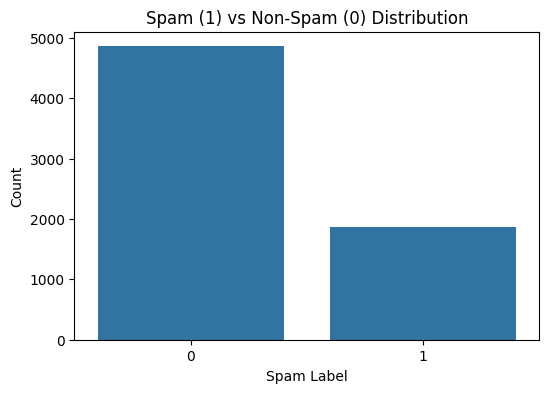

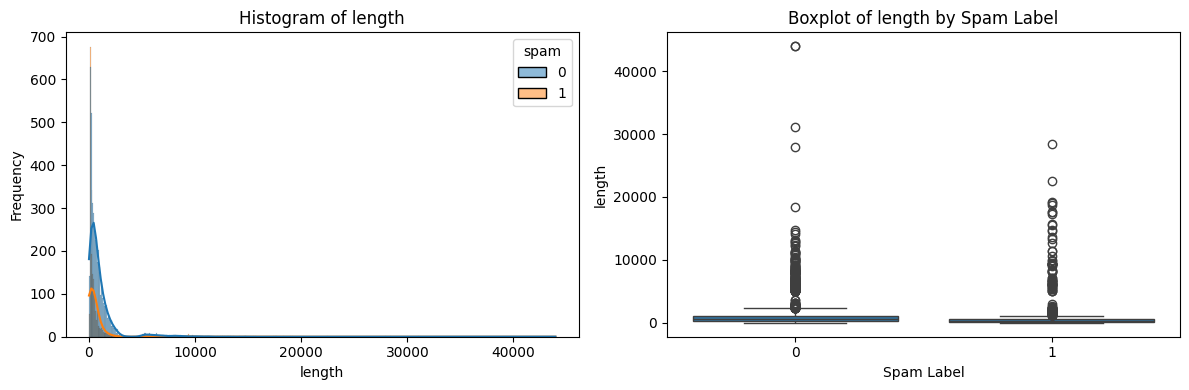

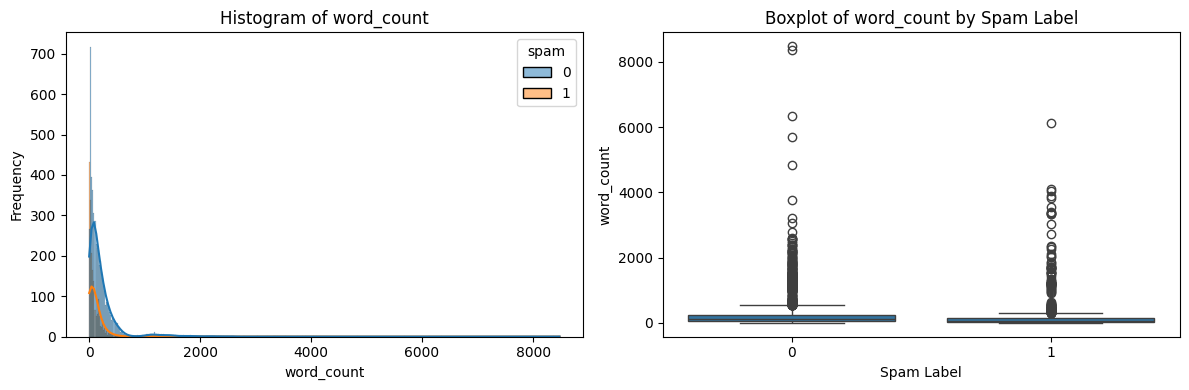

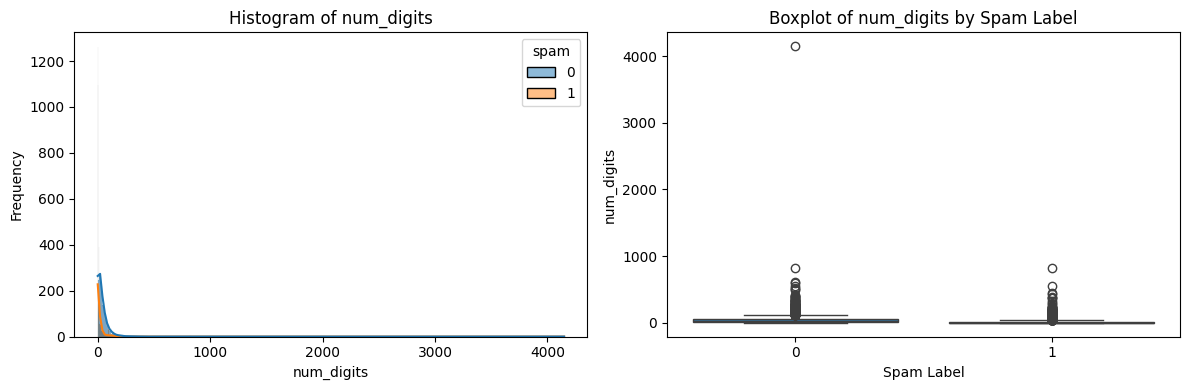

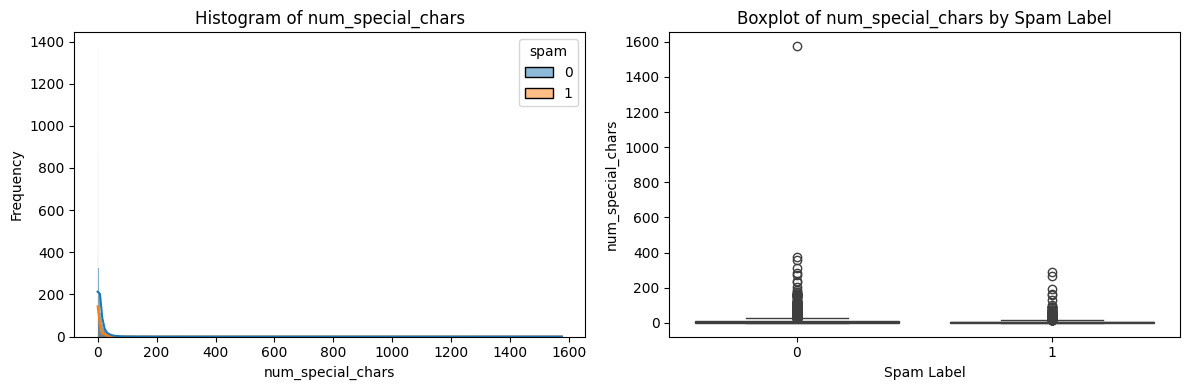

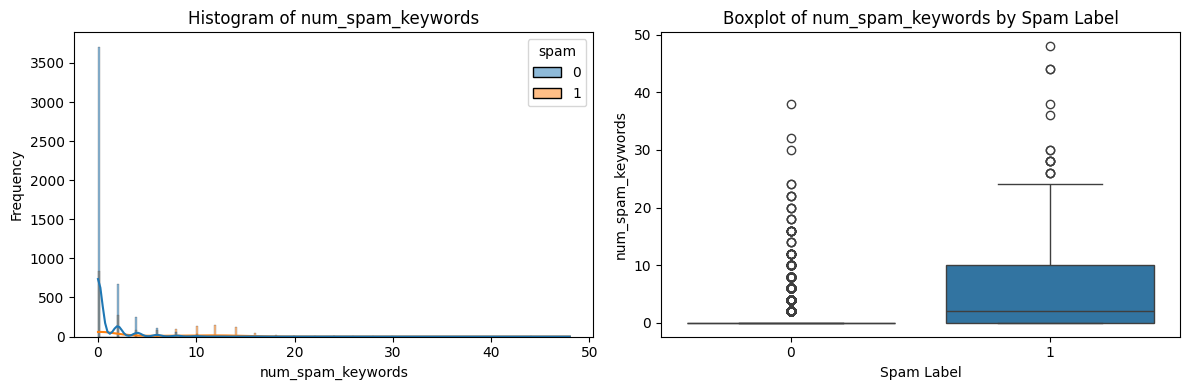

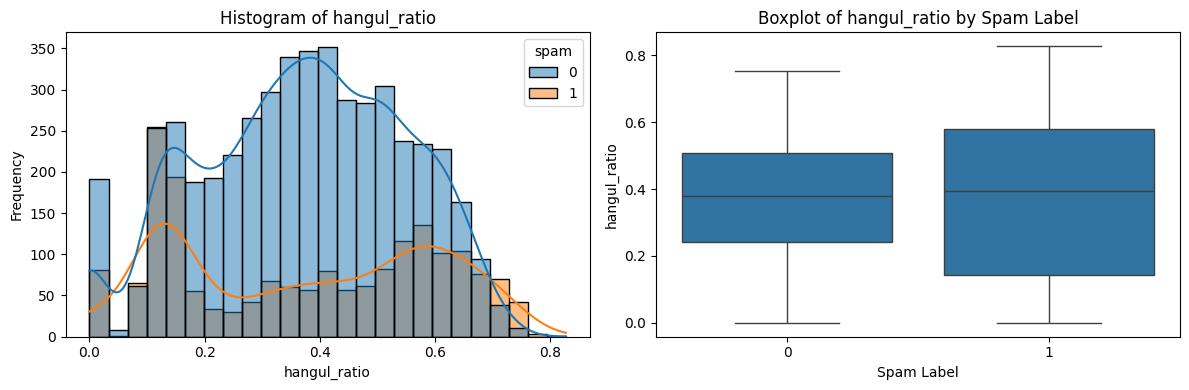

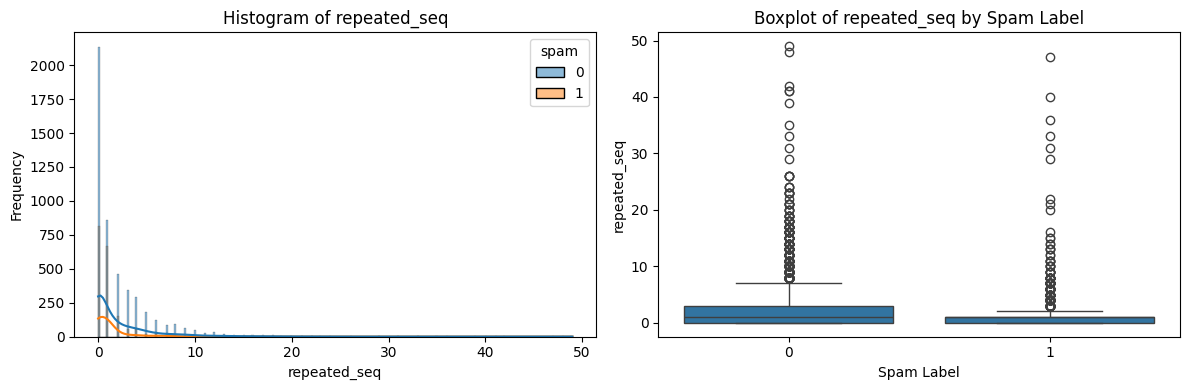

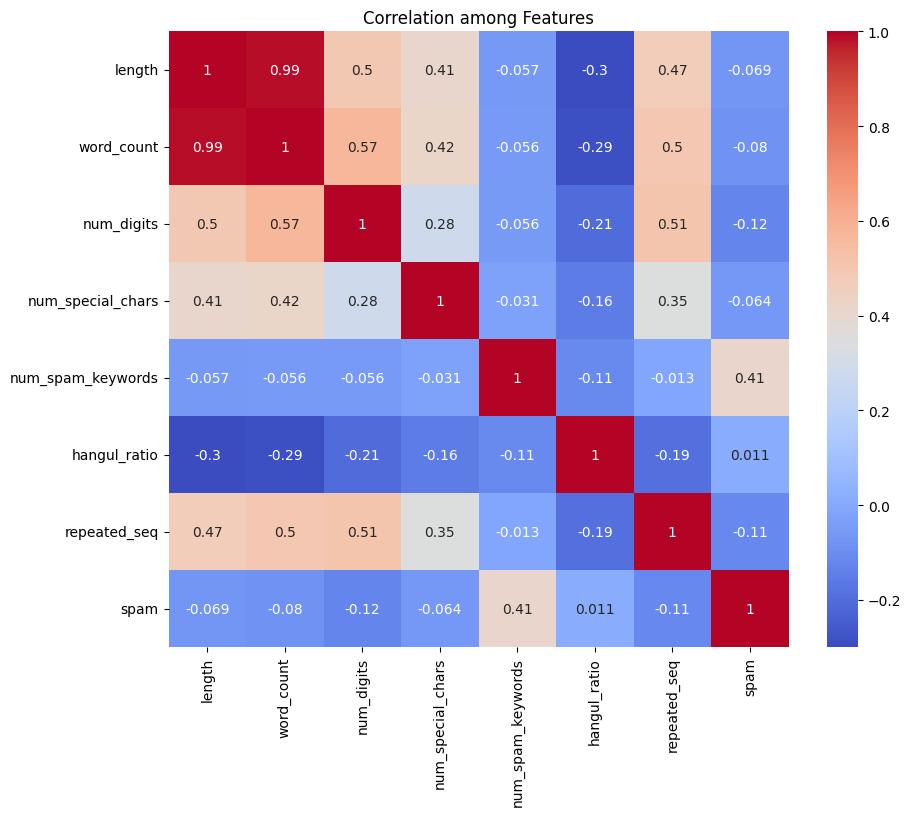

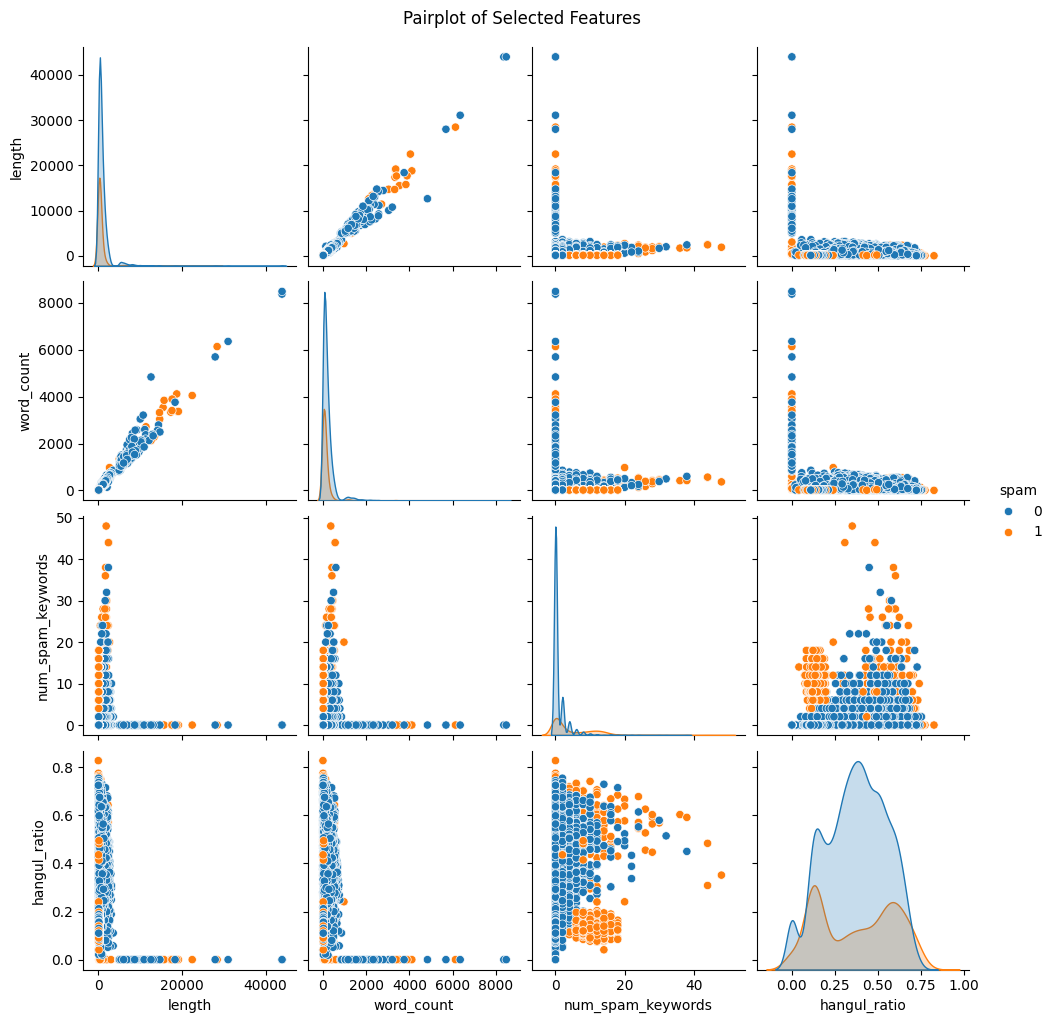

In [153]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of Spam (1) vs Non-Spam (0)
plt.figure(figsize=(6,4))
sns.countplot(x='spam', data=df)
plt.title("Spam (1) vs Non-Spam (0) Distribution")
plt.xlabel("Spam Label")
plt.ylabel("Count")
plt.show()

# %%
# Histograms and Boxplots for each feature
features_to_plot = ['length', 'word_count', 'num_digits', 'num_special_chars', 
                    'num_spam_keywords', 'hangul_ratio', 'repeated_seq']
for feature in features_to_plot:
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    
    # Histogram
    sns.histplot(data=df, x=feature, hue='spam', kde=True, ax=ax[0])
    ax[0].set_title(f"Histogram of {feature}")
    ax[0].set_xlabel(feature)
    ax[0].set_ylabel("Frequency")
    
    # Boxplot
    sns.boxplot(x='spam', y=feature, data=df, ax=ax[1])
    ax[1].set_title(f"Boxplot of {feature} by Spam Label")
    ax[1].set_xlabel("Spam Label")
    ax[1].set_ylabel(feature)
    
    plt.tight_layout()
    plt.show()

# Correlation Heatmap among features
plt.figure(figsize=(10,8))
corr = df[['length','word_count','num_digits','num_special_chars',
           'num_spam_keywords','hangul_ratio','repeated_seq','spam']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation among Features")
plt.show()

# Pairplot for selected features
sns.pairplot(df[['length','word_count','num_spam_keywords','hangul_ratio','spam']], hue='spam')
plt.suptitle("Pairplot of Selected Features", y=1.02)
plt.show()

# 4. 학습 및 테스트 데이터 분할
**Feature(피처)**: 위에서 생성한 수치형 피처들  
**Target(타겟)**: `spam` (0: 비스팸, 1: 스팸)

위의 각 feature들을 시각화한 결과 'num_spam_keyword', 'num_special_chars', 'repeated_seq'를 스팸 여부를 판단하는데 가장 중요한 피처로 판단했습니다.

In [154]:
from sklearn.model_selection import train_test_split

feature_cols = ['num_spam_keywords', 'num_special_chars', 'repeated_seq', 'word_count', 'hangul_ratio']

X = df[feature_cols]
y = df['spam']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Training set shape:", X_train.shape, "Test set shape:", X_test.shape)

Training set shape: (5386, 5) Test set shape: (1347, 5)


# 5. 여러 분류 모델 학습 및 비교
학습을 위해 다음 5가지 모델들을 사용합니다.

1) Decision Tree  
2) Random Forest  
3) XGBoost  
4) Logistic Regression  
5) Support Vector Machine (SVM)

In [155]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

models = {
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    "SVM": SVC(probability=True, random_state=42, class_weight='balanced')
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"=== {name} ===")
    print("Accuracy:", acc)
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print()
    print("=====================================")

=== DecisionTree ===
Accuracy: 0.8173719376391982
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       972
           1       0.65      0.73      0.69       375

    accuracy                           0.82      1347
   macro avg       0.77      0.79      0.78      1347
weighted avg       0.82      0.82      0.82      1347

Confusion Matrix:
[[828 144]
 [102 273]]

=== RandomForest ===
Accuracy: 0.8641425389755011
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       972
           1       0.79      0.70      0.74       375

    accuracy                           0.86      1347
   macro avg       0.84      0.81      0.82      1347
weighted avg       0.86      0.86      0.86      1347

Confusion Matrix:
[[902  70]
 [113 262]]

=== XGBoost ===
Accuracy: 0.8634001484780994
Classification Report:
              precision    recall  f1-score   su

# 6. 모델 성능 비교 및 시각화
테스트한 5개의 모델의 결과를 accuracy를 기준으로 비교합니다.

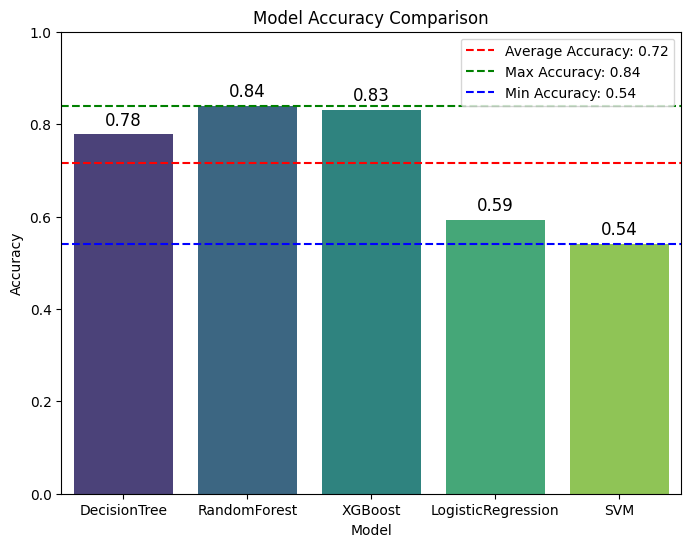

Model Accuracy Summary:
Average Accuracy: 0.7165
Max Accuracy: 0.8396
Min Accuracy: 0.5414

Best model: RandomForest (Accuracy: 0.8641)


/home/koyejune/bob-spam-email/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


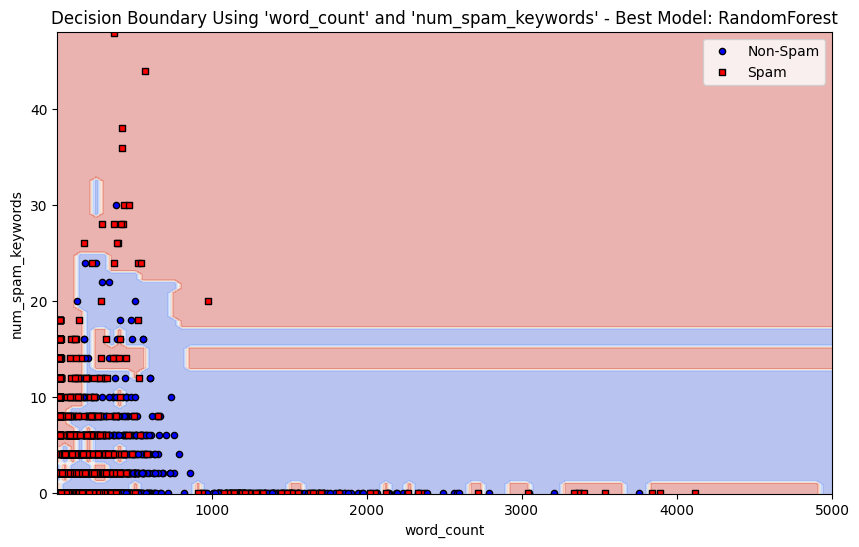

In [159]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Accuracy Bar Chart (이전 부분은 동일)
avg_accuracy = np.mean(accuracy_scores)
max_accuracy = np.max(accuracy_scores)
min_accuracy = np.min(accuracy_scores)

plt.figure(figsize=(8,6))
ax = sns.barplot(x=model_names, y=accuracy_scores, hue=model_names, palette='viridis', dodge=False)
leg = ax.get_legend()
if leg is not None:
    leg.remove()
plt.title("Model Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
for i, v in enumerate(accuracy_scores):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=12)
plt.axhline(avg_accuracy, color='red', linestyle='--', label=f"Average Accuracy: {avg_accuracy:.2f}")
plt.axhline(max_accuracy, color='green', linestyle='--', label=f"Max Accuracy: {max_accuracy:.2f}")
plt.axhline(min_accuracy, color='blue', linestyle='--', label=f"Min Accuracy: {min_accuracy:.2f}")
plt.legend()
plt.show()

print("Model Accuracy Summary:")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Max Accuracy: {max_accuracy:.4f}")
print(f"Min Accuracy: {min_accuracy:.4f}")

# Decision Boundary Visualization with custom features
x_feature = 'word_count'
y_feature = 'num_spam_keywords'

X_train_custom = X_train[[x_feature, y_feature]]
X_test_custom = X_test[[x_feature, y_feature]]

best_model_name = max(results, key=results.get)
best_model_score = results[best_model_name]
print(f"\nBest model: {best_model_name} (Accuracy: {best_model_score:.4f})")

from sklearn.base import clone
best_model_custom = clone(models[best_model_name])
best_model_custom.fit(X_train_custom, y_train)

# x축 최소값은 기존대로 계산하고, x축 최대값은 5000으로 고정합니다.
x_min = X_train_custom[x_feature].min() - 0.1
x_max = 5000  # 고정값 5000
y_min = X_train_custom[y_feature].min() - 0.1
y_max = X_train_custom[y_feature].max() + 0.1

xx, yy = np.meshgrid(np.linspace(x_min, x_max, num=100),
                     np.linspace(y_min, y_max, num=100))

Z = best_model_custom.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10,6))
plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.coolwarm)

nonspam_mask = (y_train == 0)
spam_mask = (y_train == 1)

plt.scatter(X_train_custom.loc[nonspam_mask, x_feature], 
            X_train_custom.loc[nonspam_mask, y_feature],
            marker='o', color='blue', s=20, edgecolor='k', label='Non-Spam')
plt.scatter(X_train_custom.loc[spam_mask, x_feature], 
            X_train_custom.loc[spam_mask, y_feature],
            marker='s', color='red', s=20, edgecolor='k', label='Spam')

plt.title(f"Decision Boundary Using '{x_feature}' and '{y_feature}' - Best Model: {best_model_name}")
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.xlim(x_min, x_max)
plt.legend()
plt.show()

측정 결과 random forest와 xgboost가 약 85% 정도도로 가장 높은 정확도를 보였습니다.

하지만 이를 시각화 해본 결과 두 데이터들 모두 특정 구역에 많이 모여 있는것을 확인할 수 있습니다.
이는 해당 모델의 트레이닝에 사용된 데이터 셋이 영문 이메일들을 한글로 번역하여 사용한것이기 발생하는 문제로 생각되며 충분한 한글로 된 데이터 셋이 있다면 더 좋은 결과가 나올것으로 생각됩니다.<br/>

스팸 이메일을 생성하기 위해 임의로 스팸 이메일을 생성하여 사용해보았으나나 이 경우 keyword 단일 feature로 스팸 여부를 판단하면 항상 100%의 정확도를 보이게 됩니다.
따라서 정확도가 조금 낮아 지더라고 다양한 feature를 확인해보기위해서 영문 이메일 데이터 셋을 한글로 번역한것과 섞어서 사용하였습니다.

# 7. 사용자 입력에 대한 스팸 여부 예측 함수
아래 함수를 통해, 사용자가 새로운 한국어 이메일 내용을 입력하면 바로 스팸 여부(0/1)를 예측할 수 있습니다.

In [157]:
best_model = models[best_model_name]

def predict_spam(input_text):
    """
    사용자로부터 이메일 내용을 입력받아 스팸 여부를 예측하는 함수.
    """
    temp_df = pd.DataFrame({'text': [input_text]})
    temp_df = feature_engineering(temp_df)
    
    # 모델에 필요한 피처만 추출
    temp_X = temp_df[feature_cols]
    
    pred = best_model.predict(temp_X)[0]
    return pred  # 0이면 비스팸, 1이면 스팸

print("=====================================")
# 정상 메일 테스트
test_email = """
(광고) 위메프플러스 앱 설치하고 W 포인트 2배 적립! 최대 10,000P 혜택 과 네이버페이 추가할인까지! [농협안심한우 1등급 구이용 등심 500g&불고기 500g+500g 골라담기 30,000원/ 온천수 저염 반숙계란 20구 9,900원/ 전라도 꿀고구마 3kg/5kg 8,170원] 등 인기상품들을 특가로 득템하세요!
"""
result = predict_spam(test_email)
print(f"이메일 내용: {test_email}")
print("예측 결과:", "스팸" if result == 1 else "비스팸")
print("=====================================")


# 스팸 메일 테스트
test_email = """
안녕하세요 한국정보과학회 최희수입니다.
 

요청하신 수상확인서를 첨부와 같이 전달드립니다.

내용 확인하시고 이상이 있다면 연락주시기 바랍니다.

감사합니다.
"""
result = predict_spam(test_email)
print(f"이메일 내용: {test_email}")
print("예측 결과:", "스팸" if result == 1 else "비스팸")
print("=====================================")

이메일 내용: 
(광고) 위메프플러스 앱 설치하고 W 포인트 2배 적립! 최대 10,000P 혜택 과 네이버페이 추가할인까지! [농협안심한우 1등급 구이용 등심 500g&불고기 500g+500g 골라담기 30,000원/ 온천수 저염 반숙계란 20구 9,900원/ 전라도 꿀고구마 3kg/5kg 8,170원] 등 인기상품들을 특가로 득템하세요!

예측 결과: 스팸
이메일 내용: 
안녕하세요 한국정보과학회 최희수입니다.
 

요청하신 수상확인서를 첨부와 같이 전달드립니다.

내용 확인하시고 이상이 있다면 연락주시기 바랍니다.

감사합니다.

예측 결과: 비스팸
